In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
import re
from wordcloud import WordCloud
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ndcg_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from catboost import CatBoostRanker, Pool

In [2]:
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}K'

def millions_formatter(x, pos):
    return f'{x/1000000:.0f}M'

def billions_formatter(x, pos):
    return f'{x/1000000000:.1f}B'

In [3]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


Before diving into data analysis, let's do the cleaning first.

In [4]:
videos_stats = pd.read_csv('C:/Users/anneg/Downloads/videos_stats.csv')
videos_stats.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,23/08/2022,tech,3407.0,672.0,135612.0
1,The most EXPENSIVE thing I own.,b3x28s61q3c,24/08/2022,tech,76779.0,4306.0,1758063.0
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,23/08/2022,tech,63825.0,3338.0,1564007.0
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,23/08/2022,tech,71566.0,1426.0,922918.0
4,Best Back to School Tech 2022!,ErMwWXQxHp0,08/08/2022,tech,96513.0,5155.0,1855644.0


In [5]:
videos_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1881 non-null   object 
 1   Video ID      1881 non-null   object 
 2   Published At  1881 non-null   object 
 3   Keyword       1881 non-null   object 
 4   Likes         1879 non-null   float64
 5   Comments      1879 non-null   float64
 6   Views         1879 non-null   float64
dtypes: float64(3), object(4)
memory usage: 103.0+ KB


First step would be to remove missing values and duplicates. The initial length of the dataset was 1881.

In [6]:
videos_stats['Video ID'].replace('#NAME?', np.nan, inplace=True)
videos_stats.dropna(inplace=True)
videos_stats.drop_duplicates(subset=['Video ID', 'Title'], inplace=True)
print(f"The length of the dataset after missing values' and duplicates' deletion: {len(videos_stats)}")

The length of the dataset after missing values' and duplicates' deletion: 1837


Next step would be to change the columns' type where necessary.

In [7]:
for col in ['Likes', 'Comments', 'Views']:
    videos_stats[col] = videos_stats[col].astype('Int64')
    
videos_stats['Published At'] = pd.to_datetime(videos_stats['Published At'], format = '%d/%m/%Y')

videos_stats['Keyword'] = videos_stats['Keyword'].astype('category')

videos_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1837 entries, 0 to 1878
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         1837 non-null   object        
 1   Video ID      1837 non-null   object        
 2   Published At  1837 non-null   datetime64[ns]
 3   Keyword       1837 non-null   category      
 4   Likes         1837 non-null   Int64         
 5   Comments      1837 non-null   Int64         
 6   Views         1837 non-null   Int64         
dtypes: Int64(3), category(1), datetime64[ns](1), object(2)
memory usage: 109.0+ KB


In [8]:
videos_stats.sort_index(inplace=True)

Next, let's check the distribution of **Likes**, **Comments** and **Views**.

In [9]:
num_cols = videos_stats.select_dtypes(include='number')

for col in num_cols.columns:
    Q1 = videos_stats[col].quantile(0.25)
    Q3 = videos_stats[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 3*IQR
    upper_bound = Q3 + 3*IQR
    outliers = videos_stats[(videos_stats[col] < lower_bound) | (videos_stats[col] > upper_bound)]
    percentage = len(outliers) / len(videos_stats[col]) * 100
    print(f"Percentage of outliers in {col}: {round(percentage, 2)}%")

Percentage of outliers in Likes: 10.4%
Percentage of outliers in Comments: 8.66%
Percentage of outliers in Views: 10.45%


In [10]:
videos_stats.describe()

,Published At,Likes,Comments,Views
count,1837,1837.0,1837.0,1837.0
mean,2021-05-29 15:28:07.316276480,170324.71203,7890.561786,11685172.83288
min,2007-07-16 00:00:00,-1.0,-1.0,25.0
25%,2021-02-06 00:00:00,2700.0,202.0,85052.0
50%,2022-06-13 00:00:00,14800.0,820.0,591721.0
75%,2022-08-22 00:00:00,59933.0,3375.0,2812807.0
max,2022-08-24 00:00:00,16445558.0,732818.0,4034122271.0
std,NaN,802070.68458,38209.299696,109613260.488663


In [11]:
videos_stats = videos_stats[videos_stats['Likes'] >= 0]
videos_stats = videos_stats[videos_stats['Comments'] >= 0]


The analysis showed some negative values in **Likes** and **Comments** columns, which seems to be eroneous, so we dropped these rows.

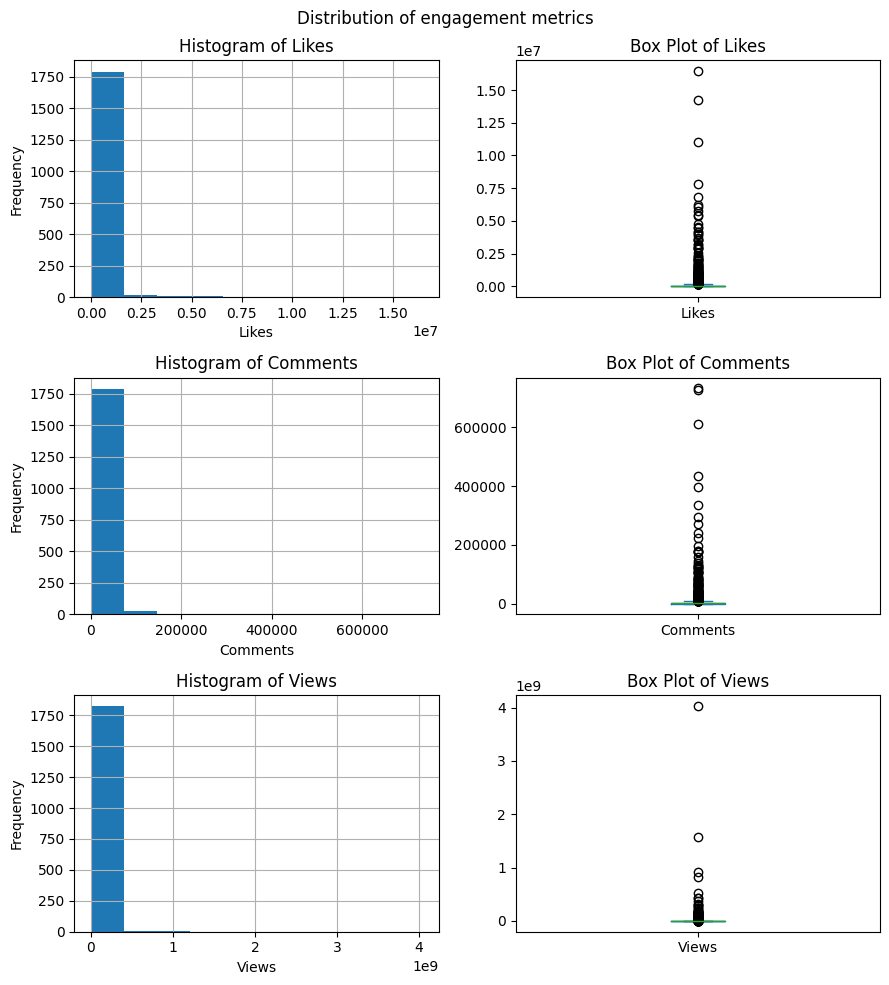

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

for i, col in enumerate(num_cols.columns):
    # Histogram
    videos_stats[col].hist(ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')

    # Box plot
    videos_stats[col].plot(kind='box', ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {col}')

plt.suptitle('Distribution of engagement metrics')
plt.tight_layout()
plt.show()

The analysis indicates that the distribution of **Likes**, **Comments**, and **Views** is highly skewed. Given the significant number of outliers, simply removing these rows may be not a good decision, as it would result in the loss of valuable information.

Now, let's take a look at the **Comments** dataset.

In [13]:
comments = pd.read_csv('C:/Users/anneg/Downloads/comments.csv')
comments.head()

,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2


In [14]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18409 entries, 0 to 18408
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Video ID   18409 non-null  object
 1   Comment    18408 non-null  object
 2   Likes      18409 non-null  int64 
 3   Sentiment  18409 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 575.4+ KB


In [15]:
comments['Video ID'] = comments['Video ID'].replace('#NAME?', np.nan)
comments.dropna(inplace=True)

comments.drop_duplicates(subset=['Video ID', 'Comment'], inplace=True)
print(f"The number of rows in the Comments dataset after cleaning: {len(comments)}")

The number of rows in the Comments dataset after cleaning: 17876


During the analysis, I observed that some of the videos were incorrectly labeled with the keyword. To ensure accurate labeling, I have reclassified these videos. Initially, there were 41 video categories, which was quite extensive. To improve clarity and manageability, I decided to regroup the videos by merging similar categories and reducing the overall number of categories.

For instance, the **bed** category initially included a variety of videos, ranging from music to entertainment. I consolidated the musical compositions into a music category and created a distinct entertainment category for the entertainment videos.

In [16]:
# Update 'Keyword' column based on patterns in 'Title' for each new keyword category
videos_stats.loc[videos_stats['Title'].str.contains('official video|official music video|audio|lyrics|remix|lyric video|official audio|pitched|sped up|neon trees|house of the rising sun|nickelback|architects|ft.|rihanna|j holiday|j. holiday|amy winehouse|jacquees|don xhoni|tiesto|pink floyd|harry styles|feat', case=False), 'Keyword'] = 'music'
videos_stats.loc[videos_stats['Title'].str.contains('asmr', case=False), 'Keyword'] = 'asmr'
videos_stats.loc[videos_stats['Title'].str.contains('gordon ramsay|food', case=False), 'Keyword'] = 'food'
videos_stats.loc[videos_stats['Title'].str.contains('python', case=False), 'Keyword'] = 'data science'
videos_stats.loc[videos_stats['Title'].str.contains('rubik', case=False), 'Keyword'] = 'cubes'
videos_stats.loc[videos_stats['Title'].str.contains('fortnite|minecraft', case=False), 'Keyword'] = 'gaming'
videos_stats.loc[videos_stats['Title'].str.contains('reaction|reactions', case=False), 'Keyword'] = 'reaction'
videos_stats.loc[videos_stats['Title'].str.contains('google', case=False), 'Keyword'] = 'google'
videos_stats.loc[videos_stats['Title'].str.contains('investors', case=False), 'Keyword'] = 'finance'
videos_stats.loc[videos_stats['Title'].str.contains('funny video|andrew tate', case = False), 'Keyword'] = 'trolling'
videos_stats.loc[videos_stats['Title'].str.contains(r'\bai\b', case=False, regex=True), 'Keyword'] = 'data science'
videos_stats.loc[videos_stats['Title'].str.contains('trump', case=False), 'Keyword'] = 'news'

In [17]:
category_mapping = {'music': 'music',
                    'tutorial': 'tutorials & how-to',
                    'trolling': 'entartainment',
                    'physics': 'education',
                    'cnn': 'media & news',
                    'mrbeast': 'entartainment',
                    'crypto': 'business & finance',
                    'interview': 'interview',
                    'game development': 'education',
                    'sat': 'education',
                    'cubes': 'entartainment',
                    'data science': 'data & ai skills',
                    'marvel': 'movie',
                    'sports': 'sports',
                    'minecraft': 'games',
                    'how-to': 'tutorials & how-to',
                    'xbox': 'games',
                    'food': 'food',
                    'reaction': 'entartainment',
                    'history': 'education', 
                    'nintendo': 'games',
                    'biology': 'education',
                    'asmr': 'entartainment',
                    'machine learning': 'data & ai skills',
                    'computer science': 'data & ai skills',
                    'literature': 'education',
                    'business': 'business & finance',
                    'tech': 'technology & internet',
                    'chess': 'education',
                    'music': 'music',
                    'bed': 'entartainment',
                    'google': 'technology & internet',
                    'mukbang': 'food',
                    'apple': 'technology & internet',
                    'lofi': 'music',
                    'movies': 'movie',
                    'gaming': 'games',
                    'finance': 'business & finance',
                    'news': 'media & news',
                    'animals': 'animals',
                    'education': 'education',
                    'mathchemistry': 'education'}

In [18]:
videos_stats['Broad Category'] = videos_stats['Keyword'].map(category_mapping)

I've created a new column **Broad Category** that includes the new video categories.

In [19]:
print(f'The number of video categories after regrouping: {videos_stats["Broad Category"].nunique()}')

The number of video categories after regrouping: 14


In [20]:
videos_stats.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views,Broad Category
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,music,3407,672,135612,music
1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779,4306,1758063,technology & internet
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825,3338,1564007,technology & internet
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,2022-08-23,tech,71566,1426,922918,technology & internet
4,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513,5155,1855644,technology & internet


The graph below illustrates the median engagement metrics— **Likes**, **Views**, and **Comments** —across different video categories. The median was chosen over the mean due to the skewness in the data distribution.

As depicted in the graph:

**Highest Likes**: Videos from the **tutorials & how-to**, **entertainment**, and **food** categories garner the most likes. These categories seem to resonate well with audiences who appreciate instructional and enjoyable content.

**Highest Comments**: **Media & news** videos receive the most comments. This is expected, as news content typically sparks substantial discussion. Additionally, tutorials & how-to and interview videos also attract significant comment engagement.

**Highest Views**: The **animals** category leads in median views. After all, who can resist watching adorable kitten videos? **Sports** and **tutorials & how-to** videos also rank high in viewership.

**Tutorials & how-to** videos are particularly noteworthy, excelling in all engagement metrics, highlighting their broad appeal and utility. On the contrary, **business & finance** videos show the lowest engagement, with fewer likes, views, and comments on average.

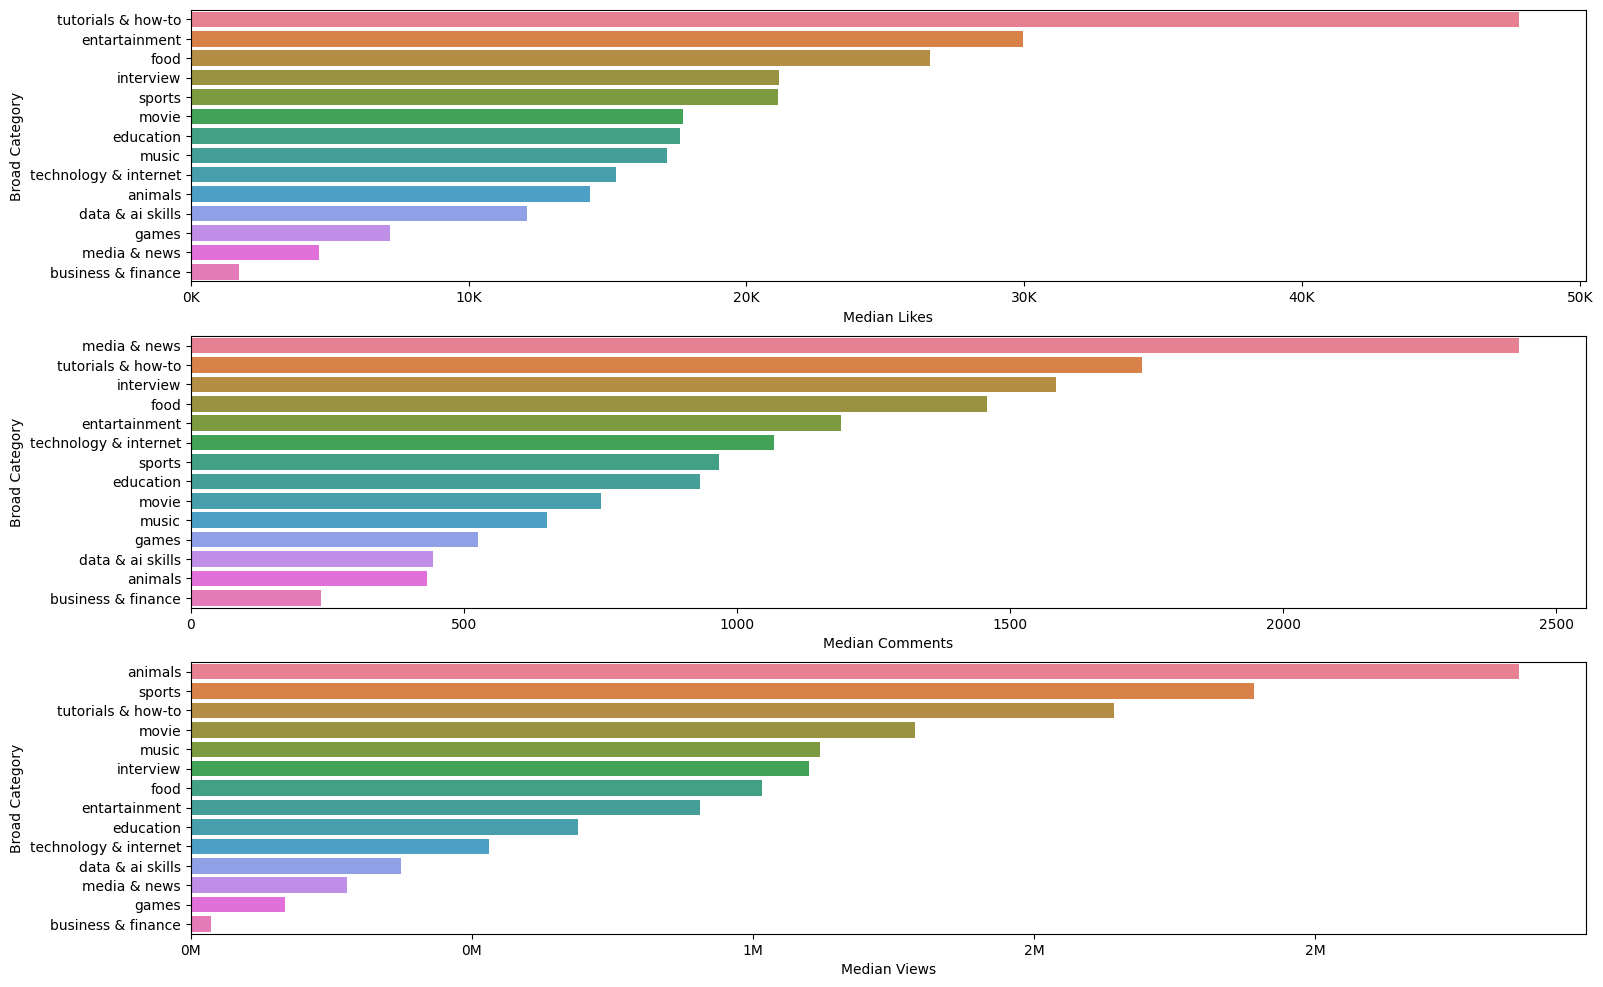

In [21]:
videos_cat = videos_stats.groupby('Broad Category').agg({'Likes':'median',
                                                         'Comments': 'median',
                                                         'Views': 'median'}).reset_index()

videos_cat.columns = ['Broad Category', 'Median Likes', 'Median Comments', 'Median Views']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))

variables_dict = {ax1: 'Median Likes',
                  ax2: 'Median Comments',
                  ax3: 'Median Views'}

for ax, variable in variables_dict.items():
    data = videos_cat.sort_values(variable, ascending=False)
    
    sns.barplot(x=variable,
                y='Broad Category', 
                data=data,
                ax=ax,
                hue='Broad Category',
                dodge=False)

ax1.get_xaxis().set_major_formatter(FuncFormatter(thousands_formatter))
ax3.get_xaxis().set_major_formatter(FuncFormatter(millions_formatter))

To identify which words frequently appear in the titles of popular videos within each category, I conducted an analysis using engagement metrics. My aim was to understand the content trends that drive audience engagement in different video categories. The analysis involved creating an engagement index that incorporates **Likes**, **Comments**, and **Views** from each video. The chosen weights for these metrics are as follows:

LIKE_WEIGHT: 1.0

COMMENT_WEIGHT: 2.0

VIEW_WEIGHT: 0.5

These weights reflect the relative significance of each metric. **Comments** are given the highest weight because they typically indicate a stronger level of engagement and emotional response compared to likes and views. **Likes** are considered to represent a moderate level of positive engagement, while **views**, having the lowest weight, signify the least engagement as they merely indicate that the video was watched.

Below, you will find word clouds showcasing the most common words found in the titles of popular videos across various categories. These visualizations provide insights into the themes and topics that resonate most with audiences in each category.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anneg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anneg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anneg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anneg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


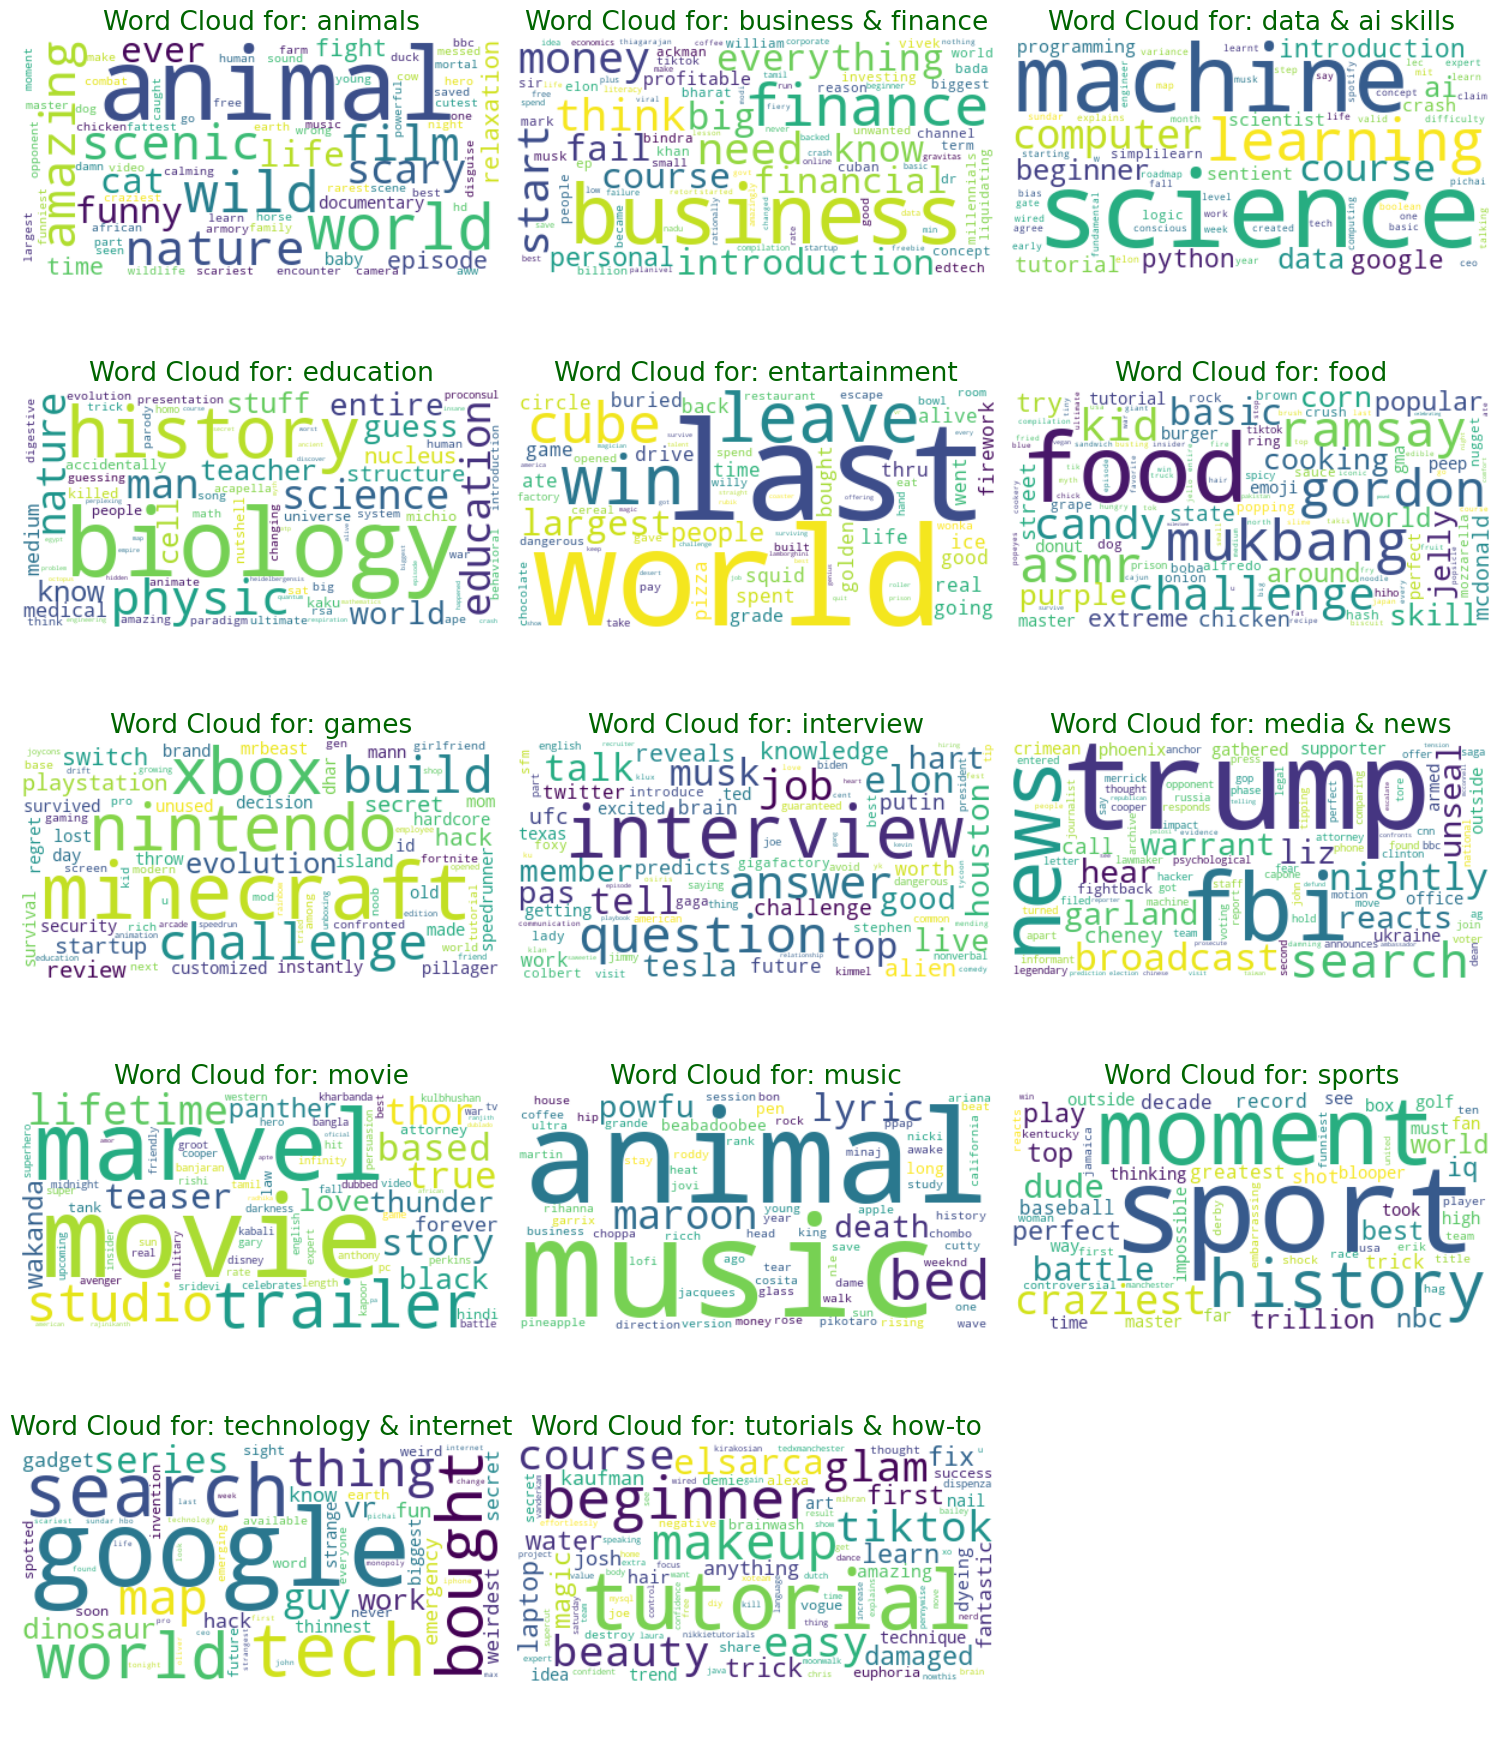

In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(stopwords.words('spanish'))  # Add Spanish stopwords as there are many Spanish words in music category
additional_stopwords = {'official', 'video', 'quot', 'amp', 'feat', 'ft', 'hour', 'hours', 'minute', 'minutes', 'seconds', 'day', 'lmn', 'tedxcsu', 'vs', 'em', 'new', 'year', 'full'}
stop_words.update(additional_stopwords)

LIKE_WEIGHT = 1.0
COMMENT_WEIGHT = 2.0
VIEW_WEIGHT = 0.5

# Function to preprocess titles
def preprocess_title(title):
    tokens = word_tokenize(title.lower())  
    return [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

# Function to check if word is English or Spanish 
def is_english_or_spanish(word):
    return re.match("^[a-zñáéíóúü]+$", word) is not None

# Calculate engagement index for each video
videos_stats['Engagement Index'] = (
    videos_stats['Likes'] * LIKE_WEIGHT +
    videos_stats['Comments'] * COMMENT_WEIGHT +
    videos_stats['Views'] * VIEW_WEIGHT
)

# Number of top videos to consider for each category
NUM_TOP_VIDEOS = 20  

top_words_per_category = defaultdict(lambda: defaultdict(int))

# Select top videos for each category based on engagement index
for category, group in videos_stats.groupby('Broad Category'):
    top_videos = group.sort_values(by='Engagement Index', ascending=False).head(NUM_TOP_VIDEOS)
    
    # Process titles of top videos
    for _, row in top_videos.iterrows():
        tokens = preprocess_title(row['Title'])  
        tokens = [token for token in tokens if is_english_or_spanish(token)]  
        tokens = [token for token in tokens if token.isalpha()]  
        for token in tokens:
            top_words_per_category[category][token] += 1  

# Generate and display word clouds for each category
fig, axes = plt.subplots(5, 3, figsize=(15, 18))
axes = axes.flatten()

for idx, (category, word_counts) in enumerate(top_words_per_category.items()):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_counts)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f"Word Cloud for: {category}", color='darkgreen', fontsize=19)
    axes[idx].axis('off')

for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.tight_layout()
plt.show()


The word clouds enabled a deeper understanding of the popularity trends within each video category. For example, in the **Food** category, words like "Gordon", "Ramsay", "food", and "mukbang" frequently appear in the titles of popular videos. This suggests that content related to celebrity chef Gordon Ramsay and eating shows is particularly engaging for this audience. In contrast, popular videos in the **Data & AI Skills** category often include words such as "machine", "learning", and "science", "course", "python", "beginner". This indicates a strong interest in machine learning and introductory Python courses among viewers, suggesting that content creators in this field might benefit from focusing on videos dedicated to machine learning and computer science, as well as beginner-level Python tutorials to attract and engage their audience effectively.

# 2. Sentiment Analysis

In [23]:
data = comments.merge(videos_stats[['Video ID', 'Title', 'Broad Category']], on='Video ID', how = 'left')

In the graph below, you can see the distribution of positive, negative, and neutral comments in the provided dataset. It is evident that the dataset is quite imbalanced, with positive comments making up approximately 62%, negative comments around 12%, and neutral comments about 26% of the total data.

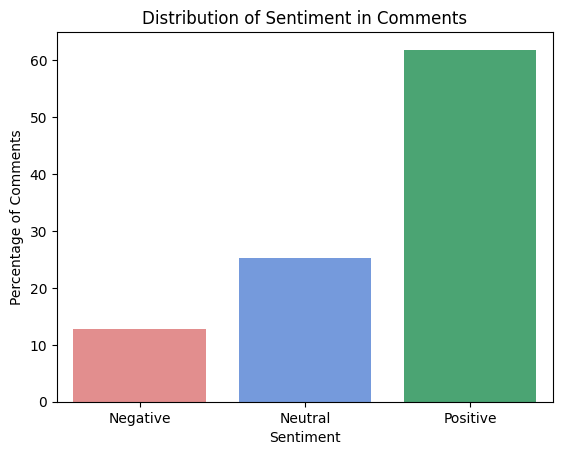

In [24]:
total_comments = len(data)  
sentiment_counts = data['Sentiment'].value_counts()
percentage = (sentiment_counts / total_comments) * 100

colors = ['lightcoral', 'cornflowerblue', 'mediumseagreen']
sns.barplot(x=percentage.index, y=percentage.values, palette=colors)
plt.xlabel('Sentiment')
plt.ylabel('Percentage of Comments')
plt.title('Distribution of Sentiment in Comments')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


To analyze the sentiment of comments, I developed a machine learning model using logistic regression to calculate the sentiment score for each comment. Here’s a detailed breakdown of the process:

1. **Text Preprocessing**

The first step involved extensive text preprocessing. This included:

Tokenization: Splitting the comments into individual words.

Alphabetic Filtering: Selecting only alphabetic characters to ensure the analysis focused on meaningful words.

Stop Words Removal: Eliminating common stop words to retain only the significant terms for sentiment analysis.

2. **Feature Engineering**

In the next step, I created several features to enhance the model's predictive capabilities:

Comment Length: Measured the length of each comment to capture the verbosity of the comment.

Log Likes: Calculated the logarithm of the likes each comment received, transforming the data to handle wide variations and emphasize relative differences.

Sentiment Score: Utilized the analyzer.polarity_scores() function to compute a sentiment score for each comment, which provided a preliminary measure of sentiment.

Broad Category: Incorporated the 'Broad Category' of the video to provide contextual information that might influence the sentiment of comments.

3. **TF-IDF Analysis**

Subsequently, I applied TF-IDF (Term Frequency-Inverse Document Frequency) analysis to transform the textual data into numerical features. This technique helped in capturing the importance of words in the context of the entire comment dataset.

4. **Model Development**

Using the preprocessed data, I trained a logistic regression model. To prevent overfitting, I conducted multiple rounds of model tuning to identify the best regularization parameter.


5. **Model Performance**

The final model achieved an accuracy of approximately **0.73** on the test set and **0.75** on the training set. This indicates a well-generalized model with minimal overfitting. The model performs well in predicting positive sentiment comments, which represent about 62% of the dataset. However, it struggles with predicting negative and neutral sentiment comments, indicating a potential area for improvement.

In [25]:
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

def sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

# Preprocess text
data['Processed Comment'] = data['Comment'].apply(preprocess_text)

# Add additional features
data['Comment Length'] = data['Comment'].apply(len)
data['Log Likes'] = np.log(data['Likes'] + 1)
data['Sentiment Score'] = data['Comment'].apply(sentiment_score)

# Define text preprocessor
text_preprocessor = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2)))  # Using unigrams and bigrams
])

# Define preprocessor with additional features
preprocessor = ColumnTransformer([
    ('text', text_preprocessor, 'Processed Comment'),
    ('numeric', StandardScaler(), ['Comment Length', 'Log Likes', 'Sentiment Score']),
    ('category', OneHotEncoder(), ['Broad Category']) 
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data[['Processed Comment', 'Comment Length', 'Log Likes', 'Sentiment Score', 'Broad Category']], 
    data['Sentiment'], 
    test_size=0.2, 
    stratify=data['Sentiment'], 
    random_state=15
)

# Define classifier
classifier = LogisticRegression(class_weight='balanced', C=0.1)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Print results
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy score: 0.7281879194630873
              precision    recall  f1-score   support

           0       0.43      0.68      0.53       460
           1       0.61      0.49      0.54       904
           2       0.87      0.83      0.85      2212

    accuracy                           0.73      3576
   macro avg       0.64      0.67      0.64      3576
weighted avg       0.75      0.73      0.73      3576

Confusion Matrix:
[[ 315   77   68]
 [ 259  442  203]
 [ 165  200 1847]]


In [26]:
predictions = pipeline.predict(data[['Processed Comment', 'Comment Length', 'Log Likes', 'Sentiment Score', 'Broad Category']])
data['Predicted Sentiment'] = predictions

Now we can leverage the comments' predicted sentiment scores from our model to compute an **overall sentiment score for each video**. Given that some comments garner significantly more likes than others, it’s crucial to assign greater weight to these highly liked comments, as they likely have a more substantial influence on the overall perception of the video.

The approach involves several steps:

**Weighting Sentiments Based on Engagement**: 

I normalize the number of likes each comment receives and then multiply this normalized value by the sentiment score derived from our model. This ensures that comments with more likes contribute more to the overall sentiment score, reflecting their higher engagement and potential impact.

**Aggregating Sentiments for Each Video**: 

I aggregate the weighted sentiment scores for all comments associated with each video. By summing these scores, we get a cumulative sentiment value for each video that accounts for both the sentiment and the engagement level of individual comments.

**Normalizing by Total Engagement**: 

To balance the influence across videos, we divide the aggregated weighted sentiment by the total number of normalized likes. This step ensures that the overall sentiment score reflects the average sentiment in proportion to the engagement level of the comments.

In the graph below, you can observe the distribution of video sentiment across different categories. Across most categories, the trend is relatively consistent, with the majority of videos being classified as positive. This indicates a general positive reception in most content categories, where viewers tend to leave more favorable comments.

An interesting outlier is the **media & news** category. Here, approximately 90% of the videos are classified as negative, with only a small fraction being neutral or positive. This could suggest that news content often elicits stronger negative reactions, possibly due to the nature of the news being reported or the emotional impact of the content.

In [27]:
# Define weights based on sentiment
weights = {0: 0.5, 1: 1, 2: 1.5}

data['Normalized Likes'] = data['Likes'] / data['Likes'].max()

data['Weighted Predicted Sentiment'] = data['Predicted Sentiment'].map(weights) * data['Normalized Likes']
video_pred_sentiment = data.groupby('Video ID').agg({
    'Weighted Predicted Sentiment': 'sum',  
    'Normalized Likes': 'sum'  
}).reset_index()
video_pred_sentiment['Overall Sentiment'] = video_pred_sentiment['Weighted Predicted Sentiment'] / video_pred_sentiment['Normalized Likes']

# Merge with video information
video_pred_sentiment = video_pred_sentiment.merge(data[['Video ID', 'Title', 'Broad Category']], on='Video ID', how='left')
video_pred_sentiment.drop_duplicates(inplace=True)

In [28]:
def classify_sentiment(row):
    if row['Overall Sentiment'] <= 0.83:
        return 0
    elif row['Overall Sentiment'] >= 1.17:
        return 2
    else:
        return 1

video_pred_sentiment['Video Predicted Sentiment'] = video_pred_sentiment.apply(classify_sentiment, axis=1)

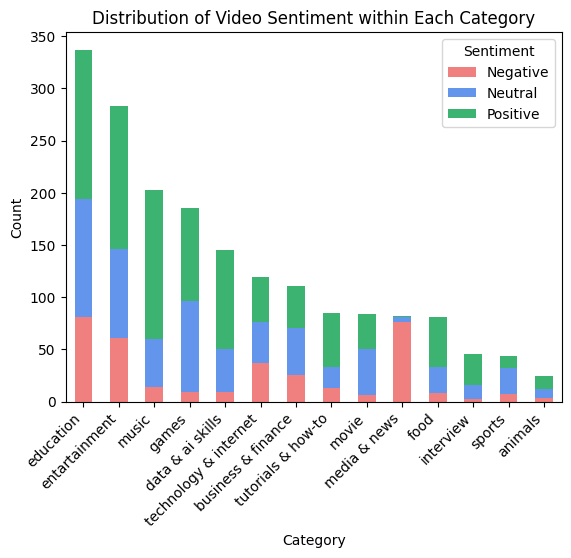

In [29]:
grouped = video_pred_sentiment.groupby('Broad Category')['Video Predicted Sentiment'].value_counts().reset_index(name='Count')
pivot_df = grouped.pivot(index='Broad Category', columns='Video Predicted Sentiment', values='Count')

# Calculate the total counts for each 'Broad_category' and sort by total count
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False).drop(columns='Total')

# Define the colors from seaborn 'muted' palette
colors = ['lightcoral', 'cornflowerblue', 'mediumseagreen']  # Mapping the colors to Negative, Neutral, Positive

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, color=colors)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Video Sentiment within Each Category')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=45, ha = 'right')

# Show the plot
plt.show()

In this section, we aim to identify and visualize the most frequent positive and negative words used in video comments across various categories. Neutral sentiments are excluded to focus on the polar extremes of viewer feedback. 

To ensure accurate sentiment analysis, I first preprocess the text of each comment, which included tokenization, lemmatization, stop words removal, and filtering out non-alphabetic characters. Then, using the VADER sentiment analysis tool, I calculate the polarity score for each word. To ensure that only distinctly positive or negative words are considered, I apply polarity thresholds:

**Positive Words**: Words with a polarity score above 0.1;

**Negative Words**: Words with a polarity score below -0.1.

This filtering helps in excluding words that might not convey strong sentiment, thus focusing on words that clearly reflect positive or negative sentiments.

For each category and sentiment type (positive or negative), I count the frequency of each word. The most frequent words are then visualized using word clouds, which provide an intuitive representation of word importance.

The result is not surprising with 'love', 'good' and 'well' - being the most common positive words and 'wrong', 'problem', 'war' and 'fail' - the most common negative ones.

In [30]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

exclude_words = {'po'}

# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop and token.lemma_.lower() not in exclude_words]
    return ' '.join(tokens)

# Function to get polarity score of a word
def word_polarity(word):
    return analyzer.polarity_scores(word)['compound']

# Function to get the most frequent words with polarity scores
def get_most_frequent_words_with_polarity(df, sentiment, category, n=10, positive_threshold=0.1, negative_threshold=-0.1):
    filtered_df = df[(df['Predicted Sentiment'] == sentiment) & (df['Broad Category'] == category)]
    words = ' '.join(filtered_df['Processed Comment']).split()
    word_freq = Counter(words)
    word_polarity_scores = {word: word_polarity(word) for word in word_freq}
    
    # Filter out words based on polarity thresholds
    if sentiment == 2:  
        filtered_word_freq = {word: freq for word, freq in word_freq.items() if word_polarity_scores[word] >= positive_threshold}
    else:  
        filtered_word_freq = {word: freq for word, freq in word_freq.items() if word_polarity_scores[word] <= negative_threshold}
    
    # Sort words by frequency first
    most_common_words = Counter(filtered_word_freq).most_common(n)
    
    # Sort the most common words by their polarity score
    if sentiment == 2:  
        sorted_words = sorted(most_common_words, key=lambda x: (word_polarity_scores[x[0]], x[1]), reverse=True)
    else:  
        sorted_words = sorted(most_common_words, key=lambda x: (word_polarity_scores[x[0]], -x[1]))
    
    return [(word, freq, word_polarity_scores[word]) for word, freq in sorted_words]


# Preprocess text
data['Processed Comment'] = data['Comment'].apply(preprocess_text)

# Filter out neutral sentiments
data_df = data[data['Predicted Sentiment'] != 1]

# Get unique categories
categories = data_df['Broad Category'].unique()

# Store the results
results = {'Category': [], 'Predicted Sentiment': [], 'Word': [], 'Frequency': [], 'Polarity': []}

# Get most frequent words for each category and sentiment with polarity scores
for category in categories:
    positive_words = get_most_frequent_words_with_polarity(data_df, sentiment=2, category=category, n=10)
    negative_words = get_most_frequent_words_with_polarity(data_df, sentiment=0, category=category, n=10)
    
    for word, freq, polarity in positive_words:
        results['Category'].append(category)
        results['Predicted Sentiment'].append('Positive')
        results['Word'].append(word)
        results['Frequency'].append(freq)
        results['Polarity'].append(polarity)
        
    for word, freq, polarity in negative_words:
        results['Category'].append(category)
        results['Predicted Sentiment'].append('Negative')
        results['Word'].append(word)
        results['Frequency'].append(freq)
        results['Polarity'].append(polarity)

# Create a dataframe to display the results
results_df = pd.DataFrame(results)

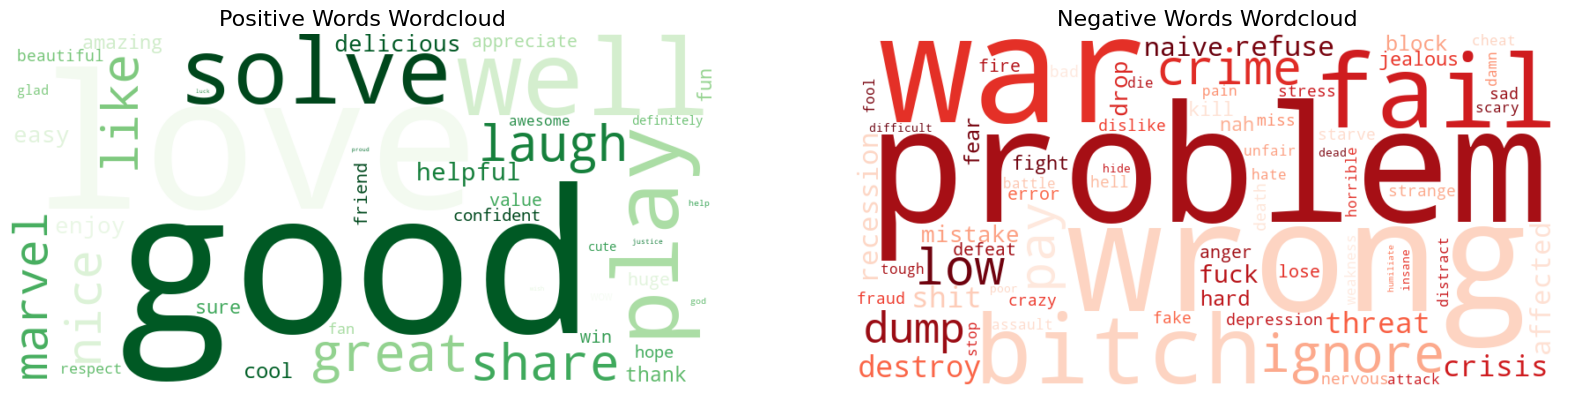

In [31]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create dictionaries of words and their frequencies
def get_word_freq_dict(df, sentiment):
    subset = df[df['Predicted Sentiment'] == sentiment]
    word_freq = dict(zip(subset['Word'], subset['Frequency']))
    return word_freq

# Generate word frequency dictionaries
positive_word_freq = get_word_freq_dict(results_df, 'Positive')
negative_word_freq = get_word_freq_dict(results_df, 'Negative')

# Create word clouds using the word frequency dictionaries
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(positive_word_freq)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_word_freq)

# Plot word clouds
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(wordcloud_positive, interpolation='bilinear')
axs[0].set_title('Positive Words Wordcloud', fontsize=16)
axs[0].axis('off')

axs[1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1].set_title('Negative Words Wordcloud', fontsize=16)
axs[1].axis('off')

plt.show()

To delve deeper, I also created bar graphs that display the most frequent positive and negative words for each specific category. These graphs highlight category-specific trends in sentiment expression:

**Positive Words**: Common positive words such as “thank,” “good,” “love,” and “great” are prevalent across most categories;

**Negative Words**: Words like “bad,” “hard,” and “problem” are frequently found in negative comments across various categories.

Only in one category - **media & news** negative words are more common than positive ones with words like "war", "lose" and "crime" being the most common.

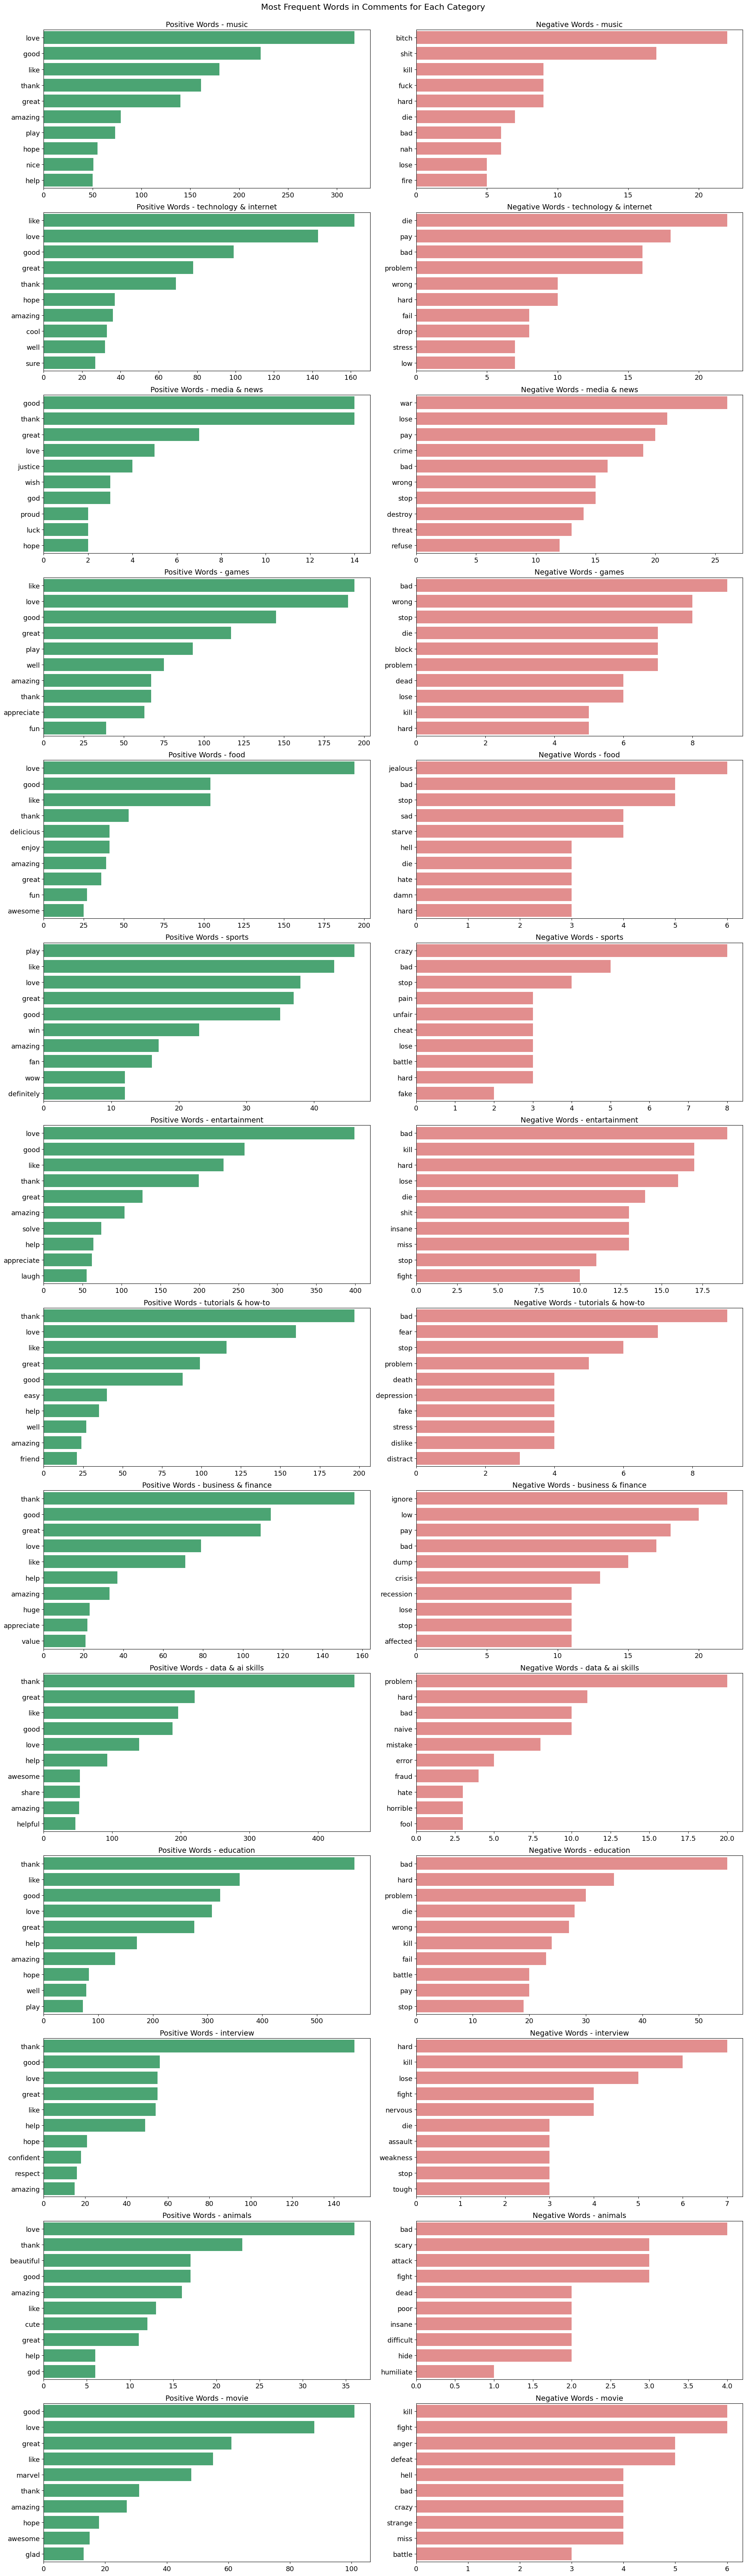

In [32]:
categories = results_df['Category'].unique()
num_categories = len(categories)

# Create subplots with `num_categories` rows and 2 columns
fig, axs = plt.subplots(num_categories, 2, figsize=(20, num_categories * 5))

for i, category in enumerate(categories):
    # Positive words subplot
    subset_positive = results_df[(results_df['Category'] == category) & (results_df['Predicted Sentiment'] == 'Positive')]
    subset_positive = subset_positive.sort_values(by='Frequency', ascending=False)
    sns.barplot(x='Frequency', y='Word', data=subset_positive, color='mediumseagreen', ax=axs[i, 0])
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_ylabel('')
    axs[i, 0].set_title(f'Positive Words - {category}', fontsize=14)
    axs[i, 0].tick_params(labelsize=13)

    # Negative words subplot
    subset_negative = results_df[(results_df['Category'] == category) & (results_df['Predicted Sentiment'] == 'Negative')]
    subset_negative = subset_negative.sort_values(by='Frequency', ascending=False)
    sns.barplot(x='Frequency', y='Word', data=subset_negative, color='lightcoral', ax=axs[i, 1])
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_ylabel('')
    axs[i, 1].set_title(f'Negative Words - {category}', fontsize=14)
    axs[i, 1].tick_params(labelsize=13)

plt.tight_layout()
plt.subplots_adjust(top=0.97)
fig.suptitle('Most Frequent Words in Comments for Each Category', fontsize=16)
plt.show()

# 3. Development of a Video Ranking Model

In [33]:
merged_pred_df = pd.merge(video_pred_sentiment[['Video ID', 'Title', 'Broad Category', 'Video Predicted Sentiment']], videos_stats[['Title', 'Video ID', 'Likes', 'Comments', 'Views', 'Broad Category']], on=['Video ID', 'Title', 'Broad Category'], how='inner')

To develop a robust video ranking model, I utilized the **CatBoost Ranker**, a powerful tool designed for ranking tasks. The model predicts a custom metric called **relevance**, which combines **engagement metrics** (likes, views, and comments) with a **video sentiment score** developed in a previous step.

**Data Preprocessing**:

**Log Transformation**: I applied a logarithmic transformation to the engagement metrics (likes, views, and comments) to normalize the data and reduce the impact of outliers.

**Normalization**: Following the log transformation, I normalized these metrics using MinMaxScaler, scaling the data to a range between 0 and 1.

**Relevance Calculation**: The relevance score is a weighted sum of the normalized engagement metrics and the video sentiment score. This approach ensures that videos with high engagement and positive sentiment are ranked higher.

**Model Training**:

I grouped videos by category to ensure that the model generates a separate ranking for each category.

The CatBoost Ranker was trained for 1,000 iterations using the YetiRank loss function, which is specifically optimized for ranking tasks. The model's performance was evaluated using the Normalized Discounted Cumulative Gain (NDCG) metric, achieving an impressive average NDCG score of 0.9998, indicating highly accurate and meaningful rankings.

In [34]:
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRanker, Pool

features_to_log_transform = ['Likes', 'Comments', 'Views']

# Apply log transform to the selected features
for feature in features_to_log_transform:
    merged_pred_df[feature] = np.log(merged_pred_df[feature] + 1)

# Define features to scale
features_to_scale = ['Likes', 'Comments', 'Views']
feature_to_exclude = 'Video Predicted Sentiment'

scaler = MinMaxScaler()
merged_pred_df[features_to_scale] = scaler.fit_transform(merged_pred_df[features_to_scale])

# Define weights
LIKE_WEIGHT = 1.0
COMMENT_WEIGHT = 2.0
VIEW_WEIGHT = 0.5
SENTIMENT_WEIGHT = 0.5

# Calculate relevance score (label) including sentiment
merged_pred_df['relevance'] = (
    merged_pred_df['Likes'] * LIKE_WEIGHT +
    merged_pred_df['Comments'] * COMMENT_WEIGHT +
    merged_pred_df['Views'] * VIEW_WEIGHT +
    merged_pred_df['Video Predicted Sentiment'] * SENTIMENT_WEIGHT
)

# Define category for grouping
merged_pred_df['group'] = merged_pred_df['Broad Category'].astype('category').cat.codes

# Check for NaN, infinite values, or values that are too large in relevance scores
merged_pred_df = merged_pred_df[np.isfinite(merged_pred_df['relevance'])]
merged_pred_df = merged_pred_df[~merged_pred_df['relevance'].isna()]

# Features and label
features = ['Likes', 'Comments', 'Views', 'Video Predicted Sentiment']
label = 'relevance'
group = 'group'  

# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    merged_pred_df[features + [group]], 
    merged_pred_df[label], 
    test_size=0.2, 
    random_state=818,  # Ensure the same split every time
    stratify=merged_pred_df[group]
)

# Concatenate features and label for sorting
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)

# Sort by group to ensure groups are contiguous
train_df = train_df.sort_values(by=group)
val_df = val_df.sort_values(by=group)

# Separate features, label, and group column
X_train = train_df[features]
y_train = train_df[label]
group_train_col = train_df[group]

X_val = val_df[features]
y_val = val_df[label]
group_val_col = val_df[group]

# Create Pool for CatBoost
train_pool = Pool(data=X_train, label=y_train, group_id=group_train_col)
val_pool = Pool(data=X_val, label=y_val, group_id=group_val_col)

# Set parameters for CatBoost
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'YetiRank',
    'custom_metric': ['NDCG'],
    'verbose': 100,
    'early_stopping_rounds': 100,
    'random_seed': 818 }

# Train the model
ranker = CatBoostRanker(**params)
ranker.fit(train_pool, eval_set=val_pool)

# Prepare the full dataset for prediction
merged_pred_df = merged_pred_df.sort_values(by=group) 
full_X = merged_pred_df[features]
full_group_col = merged_pred_df[group]

full_pool = Pool(data=full_X, group_id=full_group_col)

# Predict rankings for the entire dataset
full_predictions = ranker.predict(full_pool)

merged_pred_df['predicted_rank'] = full_predictions

merged_pred_df['rank'] = merged_pred_df.groupby(group)['predicted_rank'].rank(method='dense', ascending=False).astype(int)

# Output the final DataFrame with rankings
merged_pred_df

0:	test: 0.9890416	best: 0.9890416 (0)	total: 180ms	remaining: 2m 59s
100:	test: 0.9993881	best: 0.9995517 (28)	total: 1.13s	remaining: 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9995517046
bestIteration = 28

Shrink model to first 29 iterations.


,Video ID,Title,Broad Category,Video Predicted Sentiment,Likes,Comments,Views,relevance,group,predicted_rank,rank
1650,uLYgyR_lBS4,The Cutest Wild Baby Animals That Will Make Yo...,animals,2,0.607723,0.503212,0.573108,2.900701,0,1.294907,4
285,AGulIdSQCsY,Animals ¥GLMV¥ /Gacha Life/,animals,1,0.689234,0.543386,0.649538,2.600774,0,0.041870,14
1512,p-nh7NMWiYE,Best Funniest animals Videos 2022 🤣 - Funny Do...,animals,0,0.512447,0.363228,0.534206,1.506006,0,-2.244218,24
1644,u9X5SQCDnio,35 Hero Animals that Saved Human Lives !,animals,0,0.754887,0.691877,0.751292,2.514287,0,-0.138223,15
170,5kozt0uDa4c,Amazing Scene of Wild Animals In 4K - Scenic R...,animals,2,0.561803,0.396297,0.614614,2.661705,0,0.515115,11
...,...,...,...,...,...,...,...,...,...,...,...
1204,fJ4fvTcG43A,HOW TO GET THE &quot;DECIMATOR SHIELD&quot; in...,tutorials & how-to,1,0.250300,0.225442,0.257011,1.329691,13,-2.236246,82
1332,jL0qadiKDlQ,SPEAKING DUTCH ONLY Makeup Tutorial! | NikkieT...,tutorials & how-to,0,0.777446,0.786440,0.690398,2.695524,13,0.426918,45
1756,xqAoloAGlCE,27 EASY MAGIC TRICKS,tutorials & how-to,2,0.751014,0.643704,0.764234,3.420538,13,3.195301,3
1362,kARkOdRHaj8,How to Deal with Difficult People | Jay Johnso...,tutorials & how-to,1,0.658497,0.567116,0.629796,2.607626,13,-0.050532,54


In [35]:
val_predictions = ranker.predict(val_pool)

# Add predictions to the validation DataFrame for evaluation
val_df['predicted_rank'] = val_predictions

# Evaluate with NDCG
# Create true relevance scores as arrays for NDCG calculation
true_relevance = val_df.groupby(group)['relevance'].apply(list).values
predicted_relevance = val_df.groupby(group)['predicted_rank'].apply(list).values

# Calculate NDCG for each group and then average
ndcg_scores = [ndcg_score([true], [pred]) for true, pred in zip(true_relevance, predicted_relevance)]
average_ndcg = np.mean(ndcg_scores)

print(f'Average NDCG Score: {average_ndcg:.4f}')

Average NDCG Score: 0.9996


# 4. Strategic Recommendation for E-Learning Collaboration

To identify the top videos in the **data & AI skills** category, I used our model to rank the videos based on relevance scores. Below are the top three videos:

In [36]:
top_3_pred_videos = merged_pred_df[(merged_pred_df['Broad Category'] == 'data & ai skills') & (merged_pred_df['rank'] <= 3)]
top_3_pred_videos

,Video ID,Title,Broad Category,Video Predicted Sentiment,Likes,Comments,Views,relevance,group,predicted_rank,rank
692,OuC3wgp1Fnw,How I Learnt Machine Learning In 6 Steps (3 mo...,data & ai skills,2,0.785179,0.739890,0.666594,3.598256,2,4.064404,1
1518,pHiMN_gy9mk,2020 Machine Learning Roadmap (95% valid for 2...,data & ai skills,2,0.727257,0.657202,0.686033,3.384678,2,3.204511,2
1379,kgCUn4fQTsc,Google Engineer on His Sentient AI Claim,data & ai skills,2,0.653715,0.702571,0.604933,3.361322,2,3.125839,3


For a clearer interpretation, I also reviewed the unnormalized engagement metrics such as likes, comments, and views from our videos_stats DataFrame:

In [37]:
videos_stats[videos_stats['Video ID'].isin(['OuC3wgp1Fnw', 'NWONeJKn6kc', 'pHiMN_gy9mk'])]

,Title,Video ID,Published At,Keyword,Likes,Comments,Views,Broad Category,Engagement Index
1838,Machine Learning Course for Beginners,NWONeJKn6kc,2021-08-30,machine learning,300789,6254,11814893,data & ai skills,6220743.5
1851,2020 Machine Learning Roadmap (95% valid for 2...,pHiMN_gy9mk,2020-07-12,machine learning,176978,7152,10817160,data & ai skills,5599862.0
1858,How I Learnt Machine Learning In 6 Steps (3 mo...,OuC3wgp1Fnw,2019-10-23,machine learning,463331,21849,7497071,data & ai skills,4255564.5


The selected videos have impressive engagement metrics: likes range from 177K to 463K, comments from 6K to 21K, and views from 7M to nearly 12M. These videos are focused on machine learning for beginners, a topic that we identified as highly popular from our video titles analysis (see step 2).

However, our task is to promote an E-Learning platform that emphasizes both Data and AI skills. Notably, none of these top-ranked videos specifically addresses AI skills, a highly relevant and trending topic. Furthermore, the third video, "2020 Machine Learning Roadmap (95% valid for 2022)", although popular, may be outdated for 2024. To ensure relevance and coverage of AI, we will replace this video with the next highest-ranked video (rank 4), titled "Google Engineer on His Sentient AI Claim". This video is well-received with 13K comments and has a positive sentiment, aligning well with our focus on contemporary AI topics.

In [38]:
top_3_videos = merged_pred_df[(merged_pred_df['Broad Category'] == 'data & ai skills') & 
                              (merged_pred_df['rank'].isin([1, 2, 4]))]

recommended_videos = top_3_videos[['Video ID', 'rank', 'Video Predicted Sentiment']]

recommendations = pd.merge(recommended_videos, videos_stats, on='Video ID')

recommendations

,Video ID,rank,Video Predicted Sentiment,Title,Published At,Keyword,Likes,Comments,Views,Broad Category,Engagement Index
0,OuC3wgp1Fnw,1,2,How I Learnt Machine Learning In 6 Steps (3 mo...,2019-10-23,machine learning,463331,21849,7497071,data & ai skills,4255564.5
1,pHiMN_gy9mk,2,2,2020 Machine Learning Roadmap (95% valid for 2...,2020-07-12,machine learning,176978,7152,10817160,data & ai skills,5599862.0
2,NWONeJKn6kc,4,2,Machine Learning Course for Beginners,2021-08-30,machine learning,300789,6254,11814893,data & ai skills,6220743.5
